# EasyOCR Evaluation - auf Entitäten prüfen

Für das weitere Vorgehen ist es interessant, ob EayOCR, die relevanten Entitäten aus dem Text etxrahiert hat, denn nur diese sind für die weitere Arbeit wichtig.
Es ist nicht entscheidend, ob EasyOCR alle Textpassagen erkennt, wichtig ist, ob die gewünschten Entitäten erkannt werden.   
Dazu wird in diesem Notebook die Übereinstimmung des OCR-Outputs mit dem gelabelten ground truth überprüft.

### OCR-Output auf gewünschte Entitäten prüfen
Der extrahierte Text durch EasyOCR wurde in einem CSV gespeichert.

In [21]:
import pandas as pd

df = pd.read_csv("../../data/OCR/easyocr/easyocr_evaluation_01_0_linewise.csv")
df.head(2)

,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc,ocr_easyocr,recognition_rate
0,0001.jpg,6,6,6,0.022222,0.250000,0.976984,0.750000,"['SPRACHCAFE', 'WEIFNACHTSFEIER', 'DIENSTAG 21...",1.000000
1,0002.jpg,7,7,6,0.194740,0.416667,0.799624,0.583333,"['SchlIEsst Eucx Any', 'EI Videc & Contert', '...",0.857143


#### auf vorhandene Entitäten prüfen - ganzer Datensatz

In [28]:
import json
import pandas as pd

JSON_PATH = "../../data/data_annotated.json"
CSV_PATH = "../../data/OCR/easyocr/easyocr_evaluation_01_0_linewise.csv"
OUTPUT_PATH = "../../data/OCR/easyocr/easyocr_evaluation_01_2_entity.csv"

# JSON & CSV laden
with open(JSON_PATH, "r", encoding="utf-8") as f:
    gt_data = json.load(f)

ocr_df = pd.read_csv(CSV_PATH)

# NaN in 'ocr_text' durch leeren String ersetzen
ocr_df["ocr_easyocr"] = ocr_df["ocr_easyocr"].fillna("")

# Alle Labels, die wir tracken wollen
labels_to_track = ["EVENT", "TOPIC", "DATE", "TIME", "LOC"]

# Ergebnisliste
results = []

for gt_entry in gt_data:
    file_name = gt_entry["file_name"]
    gt_entities = gt_entry.get("entities", [])

    # OCR-Text zur Datei holen
    ocr_row = ocr_df[ocr_df["file_name"] == file_name]
    if ocr_row.empty:
        print(f"OCR-Text für {file_name} nicht gefunden – übersprungen.")
        continue
    ocr_text = ocr_row.iloc[0]["ocr_easyocr"]

    # Initiale Zähler
    result_row = {"file_name": file_name}
    for label in labels_to_track:
        result_row[f"Anzahl_{label}_gt"] = 0
        result_row[f"Anzahl_{label}_erkannt"] = 0

    erkannte_entitaeten = []
    nicht_erkannte_entitaeten = []

    for ent in gt_entities:
        label = ent["label"]
        text = ent["text"]

        if label not in labels_to_track:
            continue

        # Ground-Truth-Zähler erhöhen
        result_row[f"Anzahl_{label}_gt"] += 1

        # Prüfen, ob Text im OCR vorkommt
        if text in ocr_text:
            result_row[f"Anzahl_{label}_erkannt"] += 1
            erkannte_entitaeten.append(f"[{label}] {text}")
        else:
            nicht_erkannte_entitaeten.append(f"[{label}] {text}")

    # Listen speichern als Strings
    result_row["erkannte_entities"] = "; ".join(erkannte_entitaeten)
    result_row["nicht_erkannte_entities"] = "; ".join(nicht_erkannte_entitaeten)

    results.append(result_row)

# In DataFrame umwandeln und speichern
df_result = pd.DataFrame(results)
df_result.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")

print(f"Auswertung gespeichert in: {OUTPUT_PATH}")

Auswertung gespeichert in: ../../data/OCR/easyocr/easyocr_evaluation_01_2_entity.csv


In [29]:
df = pd.read_csv("../../data/OCR/easyocr/easyocr_evaluation_01_2_entity.csv")
df.head()

,file_name,Anzahl_EVENT_gt,Anzahl_EVENT_erkannt,Anzahl_TOPIC_gt,Anzahl_TOPIC_erkannt,Anzahl_DATE_gt,Anzahl_DATE_erkannt,Anzahl_TIME_gt,Anzahl_TIME_erkannt,Anzahl_LOC_gt,Anzahl_LOC_erkannt,erkannte_entities,nicht_erkannte_entities
0,0001.jpg,1,0,0,0,2,1,1,1,2,2,[DATE] DIENSTAG; [TIME] 19 UHR; [LOC] SPRACHCA...,[EVENT] WEIHNACHTSFEIER; [DATE] 21.12.
1,0002.jpg,1,1,1,1,1,1,1,1,2,2,[EVENT] KUNDGEBUNG; [TOPIC] SOLIDARITÄT MIT AL...,NaN
2,0003.jpg,2,2,1,0,1,0,1,1,3,3,[EVENT] Gedenkkundgebung; [EVENT] Demonstratio...,[TOPIC] Solidarität mit den Opfern des deutsch...
3,0004.jpg,1,0,0,0,2,2,1,0,2,2,[DATE] MITTWOCH; [DATE] 21. JUNI 2023; [LOC] G...,[EVENT] FEIERABEND SINGEN; [TIME] 17.00 UHR
4,0006.jpg,1,1,1,1,1,0,1,0,0,0,[EVENT] DEMO; [TOPIC] GEGEN GENTRIFIZIERUNG,[DATE] 09. JULI 2022; [TIME] 15:00 UHR


#### Entitäten Erkennungsrate berechnen

In [30]:
import pandas as pd


def berechne_erkennungsraten(csv_datei):
    # CSV laden
    df = pd.read_csv(csv_datei)

    # Entitäten, für die Erkennungsraten berechnet werden sollen
    entities = ["EVENT", "TOPIC", "DATE", "TIME", "LOC"]

    # Für jede Entität die Erkennungsrate berechnen
    for ent in entities:
        gt_col = f"Anzahl_{ent}_gt"
        erk_col = f"Anzahl_{ent}_erkannt"
        rate_col = f"Erkennungsrate_{ent}"

        # Division mit Schutz vor 0
        df[rate_col] = df[erk_col] / df[gt_col]
        df[rate_col] = df[rate_col].replace([float("inf"), float("-inf")], 0).fillna(0)

    return df

In [31]:
CSV_PATH = "../../data/OCR/easyocr/easyocr_evaluation_01_2_entity.csv"

df_ergebnisse = berechne_erkennungsraten(CSV_PATH)

df_ergebnisse.head()

,file_name,Anzahl_EVENT_gt,Anzahl_EVENT_erkannt,Anzahl_TOPIC_gt,Anzahl_TOPIC_erkannt,Anzahl_DATE_gt,Anzahl_DATE_erkannt,Anzahl_TIME_gt,Anzahl_TIME_erkannt,Anzahl_LOC_gt,Anzahl_LOC_erkannt,erkannte_entities,nicht_erkannte_entities,Erkennungsrate_EVENT,Erkennungsrate_TOPIC,Erkennungsrate_DATE,Erkennungsrate_TIME,Erkennungsrate_LOC
0,0001.jpg,1,0,0,0,2,1,1,1,2,2,[DATE] DIENSTAG; [TIME] 19 UHR; [LOC] SPRACHCA...,[EVENT] WEIHNACHTSFEIER; [DATE] 21.12.,0.0,0.0,0.5,1.0,1.0
1,0002.jpg,1,1,1,1,1,1,1,1,2,2,[EVENT] KUNDGEBUNG; [TOPIC] SOLIDARITÄT MIT AL...,NaN,1.0,1.0,1.0,1.0,1.0
2,0003.jpg,2,2,1,0,1,0,1,1,3,3,[EVENT] Gedenkkundgebung; [EVENT] Demonstratio...,[TOPIC] Solidarität mit den Opfern des deutsch...,1.0,0.0,0.0,1.0,1.0
3,0004.jpg,1,0,0,0,2,2,1,0,2,2,[DATE] MITTWOCH; [DATE] 21. JUNI 2023; [LOC] G...,[EVENT] FEIERABEND SINGEN; [TIME] 17.00 UHR,0.0,0.0,1.0,0.0,1.0
4,0006.jpg,1,1,1,1,1,0,1,0,0,0,[EVENT] DEMO; [TOPIC] GEGEN GENTRIFIZIERUNG,[DATE] 09. JULI 2022; [TIME] 15:00 UHR,1.0,1.0,0.0,0.0,0.0


In [32]:
df_ergebnisse.to_csv("../../data/OCR/easyocr/easyocr_evaluation_01_2_entity.csv", index=False)

In [33]:
df2 = pd.read_csv("../../data/OCR/easyocr/easyocr_evaluation_01_2_entity.csv")

In [34]:
df2.head(2)

,file_name,Anzahl_EVENT_gt,Anzahl_EVENT_erkannt,Anzahl_TOPIC_gt,Anzahl_TOPIC_erkannt,Anzahl_DATE_gt,Anzahl_DATE_erkannt,Anzahl_TIME_gt,Anzahl_TIME_erkannt,Anzahl_LOC_gt,Anzahl_LOC_erkannt,erkannte_entities,nicht_erkannte_entities,Erkennungsrate_EVENT,Erkennungsrate_TOPIC,Erkennungsrate_DATE,Erkennungsrate_TIME,Erkennungsrate_LOC
0,0001.jpg,1,0,0,0,2,1,1,1,2,2,[DATE] DIENSTAG; [TIME] 19 UHR; [LOC] SPRACHCA...,[EVENT] WEIHNACHTSFEIER; [DATE] 21.12.,0.0,0.0,0.5,1.0,1.0
1,0002.jpg,1,1,1,1,1,1,1,1,2,2,[EVENT] KUNDGEBUNG; [TOPIC] SOLIDARITÄT MIT AL...,NaN,1.0,1.0,1.0,1.0,1.0


In [35]:
mean_reg_rate_Event = df2["Erkennungsrate_EVENT"].mean()
mean_reg_rate_Topic = df2["Erkennungsrate_TOPIC"].mean()
mean_reg_rate_Date = df2["Erkennungsrate_DATE"].mean()
mean_reg_rate_Time = df2["Erkennungsrate_TIME"].mean()
mean_reg_rate_Loc = df2["Erkennungsrate_LOC"].mean()

reg_rate_ALL = (mean_reg_rate_Event + mean_reg_rate_Topic + mean_reg_rate_Date + mean_reg_rate_Time + mean_reg_rate_Loc) / 5


print(f"Erkennungsrate gesamt: {reg_rate_ALL:.3f}")
print(f"Erkennungsrate pro Entität:")
print(f"Event: {mean_reg_rate_Event:.3f}")
print(f"Topic: {mean_reg_rate_Topic:.3f}")
print(f"Date: {mean_reg_rate_Date:.3f}")
print(f"Time: {mean_reg_rate_Time:.3f}")
print(f"Loc: {mean_reg_rate_Loc:.3f}")


Erkennungsrate gesamt: 0.474
Erkennungsrate pro Entität:
Event: 0.623
Topic: 0.145
Date: 0.612
Time: 0.327
Loc: 0.661


#### für weitere Analysen csv Dateien mergen

In [36]:
df = pd.read_csv("../../data/image_data_with_groundtruth.csv")

In [37]:
# Nur Spalten filtern, die du brauchst
df_reduced = df[["file_name", "category"]]

# Join über name und file_name
merged = pd.merge(df_reduced, df2, on="file_name", how="left")

merged.head(2)


,file_name,category,Anzahl_EVENT_gt,Anzahl_EVENT_erkannt,Anzahl_TOPIC_gt,Anzahl_TOPIC_erkannt,Anzahl_DATE_gt,Anzahl_DATE_erkannt,Anzahl_TIME_gt,Anzahl_TIME_erkannt,Anzahl_LOC_gt,Anzahl_LOC_erkannt,erkannte_entities,nicht_erkannte_entities,Erkennungsrate_EVENT,Erkennungsrate_TOPIC,Erkennungsrate_DATE,Erkennungsrate_TIME,Erkennungsrate_LOC
0,0001.jpg,noisy,1,0,0,0,2,1,1,1,2,2,[DATE] DIENSTAG; [TIME] 19 UHR; [LOC] SPRACHCA...,[EVENT] WEIHNACHTSFEIER; [DATE] 21.12.,0.0,0.0,0.5,1.0,1.0
1,0002.jpg,noisy,1,1,1,1,1,1,1,1,2,2,[EVENT] KUNDGEBUNG; [TOPIC] SOLIDARITÄT MIT AL...,NaN,1.0,1.0,1.0,1.0,1.0


In [38]:
avg_reg_rate_EVENT_per_category = merged.groupby("category")["Erkennungsrate_EVENT"].mean() 
print((avg_reg_rate_EVENT_per_category).sort_values(ascending=False))

category
simple    0.710256
noisy     0.688889
fancy     0.567901
skewed    0.553763
photo     0.500000
Name: Erkennungsrate_EVENT, dtype: float64


In [39]:
avg_reg_rate_TOPIC_per_category = merged.groupby("category")["Erkennungsrate_TOPIC"].mean() 
print((avg_reg_rate_TOPIC_per_category).sort_values(ascending=False))

category
simple    0.261538
noisy     0.194444
fancy     0.092593
skewed    0.032258
photo     0.008333
Name: Erkennungsrate_TOPIC, dtype: float64


In [40]:
avg_reg_rate_DATE_per_category = merged.groupby("category")["Erkennungsrate_DATE"].mean() 
print((avg_reg_rate_DATE_per_category).sort_values(ascending=False))

category
simple    0.757692
skewed    0.586022
noisy     0.550000
fancy     0.540123
photo     0.466667
Name: Erkennungsrate_DATE, dtype: float64


In [41]:
avg_reg_rate_TIME_per_category = merged.groupby("category")["Erkennungsrate_TIME"].mean() 
print((avg_reg_rate_TIME_per_category).sort_values(ascending=False))

category
noisy     0.477778
simple    0.411538
skewed    0.311828
photo     0.225000
fancy     0.188272
Name: Erkennungsrate_TIME, dtype: float64


In [42]:
avg_reg_rate_LOC_per_category = merged.groupby("category")["Erkennungsrate_LOC"].mean() 
print((avg_reg_rate_LOC_per_category).sort_values(ascending=False))

category
simple    0.774615
noisy     0.755556
skewed    0.678187
fancy     0.526235
photo     0.491667
Name: Erkennungsrate_LOC, dtype: float64


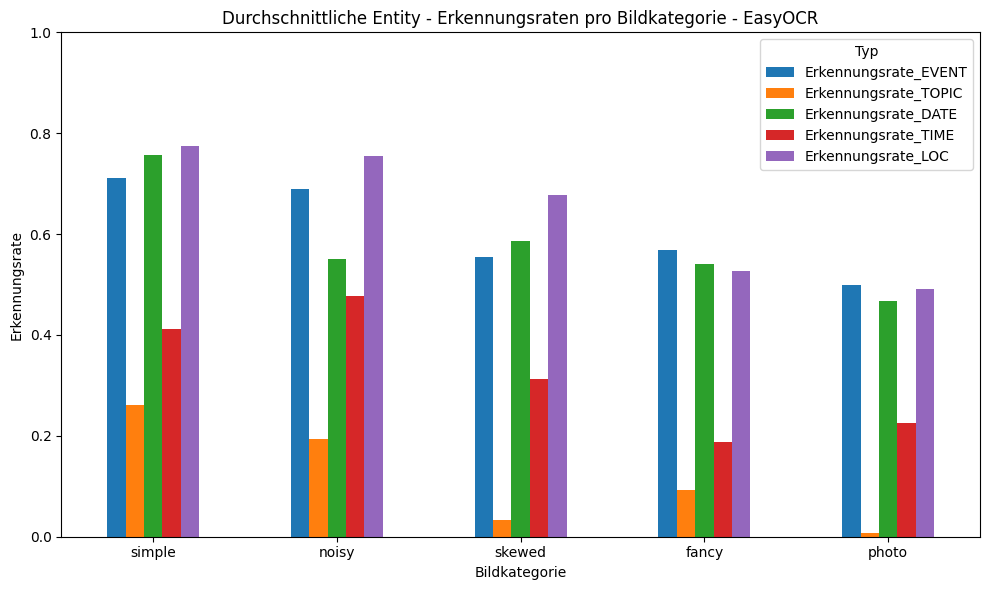

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Mittelwerte berechnen
avg_event = merged.groupby("category")["Erkennungsrate_EVENT"].mean()
avg_topic = merged.groupby("category")["Erkennungsrate_TOPIC"].mean()
avg_date = merged.groupby("category")["Erkennungsrate_DATE"].mean()
avg_time = merged.groupby("category")["Erkennungsrate_TIME"].mean()
avg_loc = merged.groupby("category")["Erkennungsrate_LOC"].mean()

# Zusammenführen zu einem DataFrame
df_combined = pd.DataFrame({
    "Erkennungsrate_EVENT": avg_event,
    "Erkennungsrate_TOPIC": avg_topic,
    "Erkennungsrate_DATE": avg_date,
    "Erkennungsrate_TIME": avg_time,
    "Erkennungsrate_LOC": avg_loc
})

# Eigene Reihenfolge definieren
category_order = ['simple', 'noisy', 'skewed', 'fancy', 'photo']
df_combined = df_combined.loc[category_order]


# Plot
ax = df_combined.plot(kind="bar", figsize=(10, 6))
plt.title("Durchschnittliche Entity - Erkennungsraten pro Bildkategorie - EasyOCR")
plt.ylabel("Erkennungsrate")
plt.xlabel("Bildkategorie")
plt.xticks(rotation=0)
plt.legend(title="Typ")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


---

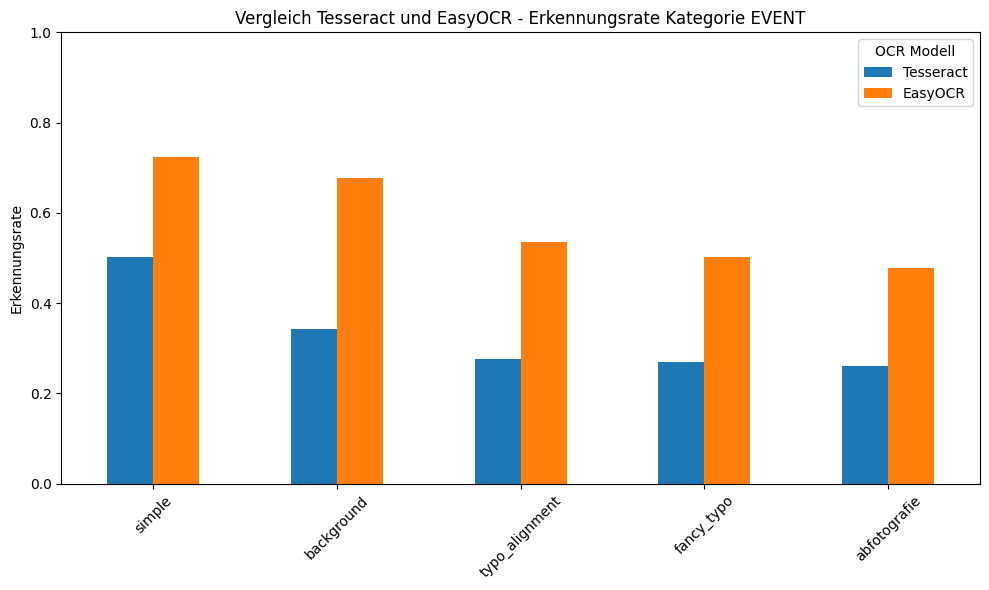

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Beispielhafte Daten – diese musst du mit deinen echten Werten ersetzen
event_easy= {
    'simple': 0.723039,
    'background': 0.677083,
    'typo_alignment': 0.536458,
    'fancy_typo': 0.502525,
    'abfotografie': 0.478261
}

event_tesser = {
    'simple': 0.502451,
    'background': 0.343750,
    'typo_alignment': 0.276042,
    'fancy_typo': 0.270202,
    'abfotografie': 0.260870
}





kategorie_reihenfolge = ['simple', 'background', 'typo_alignment', 'fancy_typo', 'abfotografie']

# In DataFrame umwandeln
df = pd.DataFrame({
    'Tesseract': event_tesser,
    'EasyOCR': event_easy,
})

# Sortierung einheitlich nach Kategorie
#df = df.sort_index()
df = df.loc[kategorie_reihenfolge]

# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Erkennungsrate')
plt.title('Vergleich Tesseract und EasyOCR - Erkennungsrate Kategorie EVENT')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='OCR Modell')
plt.tight_layout()
plt.show()

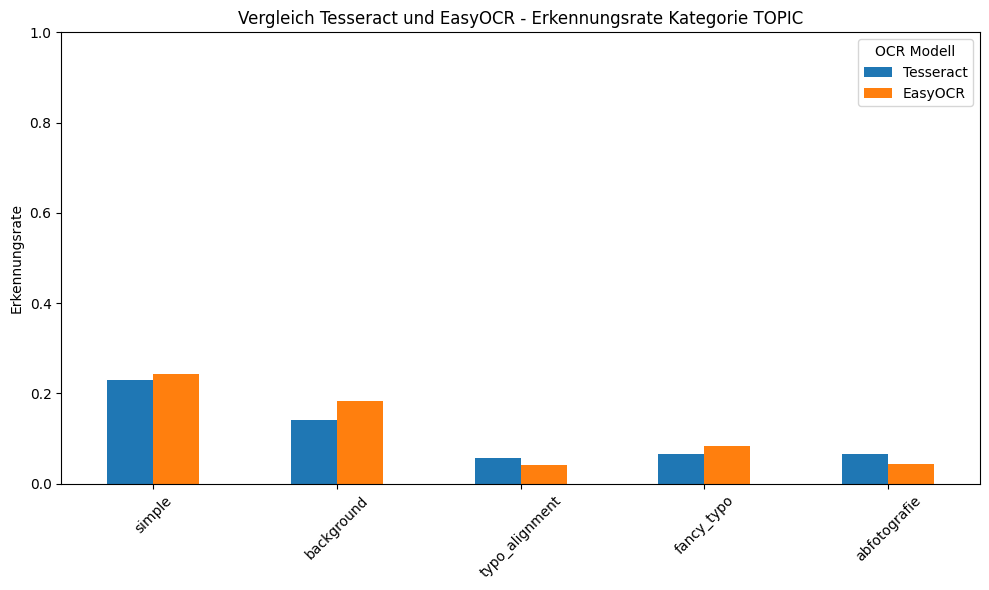

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Beispielhafte Daten – diese musst du mit deinen echten Werten ersetzen
category_easy= {
    'simple': 0.242647,
    'background': 0.182292,
    'fancy_typo': 0.083333,
    'abfotografie': 0.043478,
    'typo_alignment': 0.041667
}

category_tesser = {
    'simple': 0.230392,
    'background': 0.140625,
    'fancy_typo': 0.065657,
    'abfotografie': 0.065217,
    'typo_alignment': 0.057292
}





kategorie_reihenfolge = ['simple', 'background', 'typo_alignment', 'fancy_typo', 'abfotografie']

# In DataFrame umwandeln
df = pd.DataFrame({
    'Tesseract': category_tesser,
    'EasyOCR': category_easy,
})

# Sortierung einheitlich nach Kategorie
#df = df.sort_index()
df = df.loc[kategorie_reihenfolge]

# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Erkennungsrate')
plt.title('Vergleich Tesseract und EasyOCR - Erkennungsrate Kategorie TOPIC')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='OCR Modell')
plt.tight_layout()
plt.show()

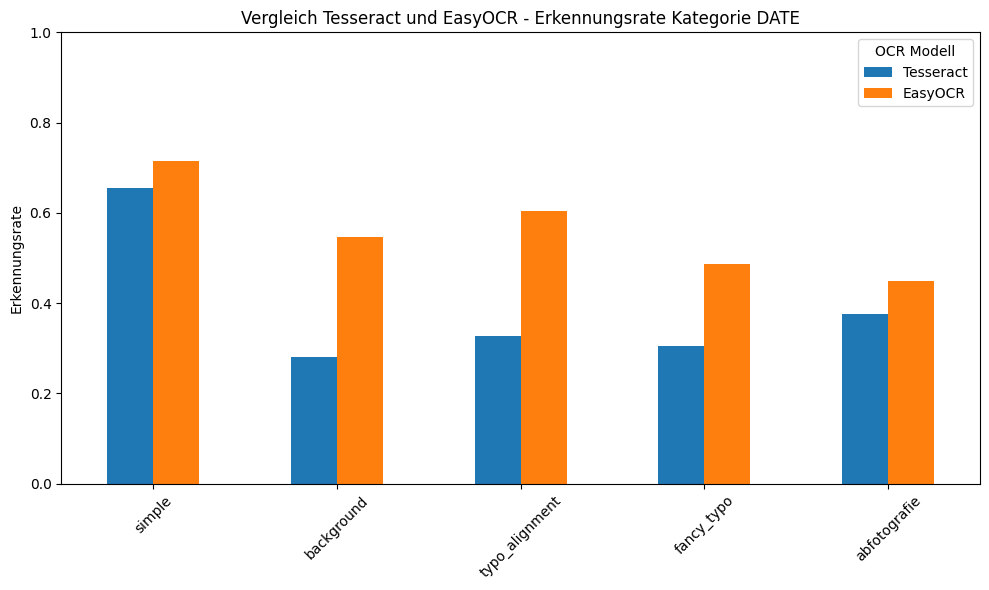

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Beispielhafte Daten – diese musst du mit deinen echten Werten ersetzen
category_easy= {
    'simple': 0.714461,
    'background': 0.546875,
    'typo_alignment': 0.604167,
    'fancy_typo': 0.487374,
    'abfotografie': 0.449275
}

category_tesser = {
    'simple': 0.654412,
    'background': 0.281250,
    'typo_alignment': 0.328125,
    'fancy_typo': 0.305556,
    'abfotografie': 0.376812
}





kategorie_reihenfolge = ['simple', 'background', 'typo_alignment', 'fancy_typo', 'abfotografie']

# In DataFrame umwandeln
df = pd.DataFrame({
    'Tesseract': category_tesser,
    'EasyOCR': category_easy,
})

# Sortierung einheitlich nach Kategorie
#df = df.sort_index()
df = df.loc[kategorie_reihenfolge]

# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Erkennungsrate')
plt.title('Vergleich Tesseract und EasyOCR - Erkennungsrate Kategorie DATE')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='OCR Modell')
plt.tight_layout()
plt.show()

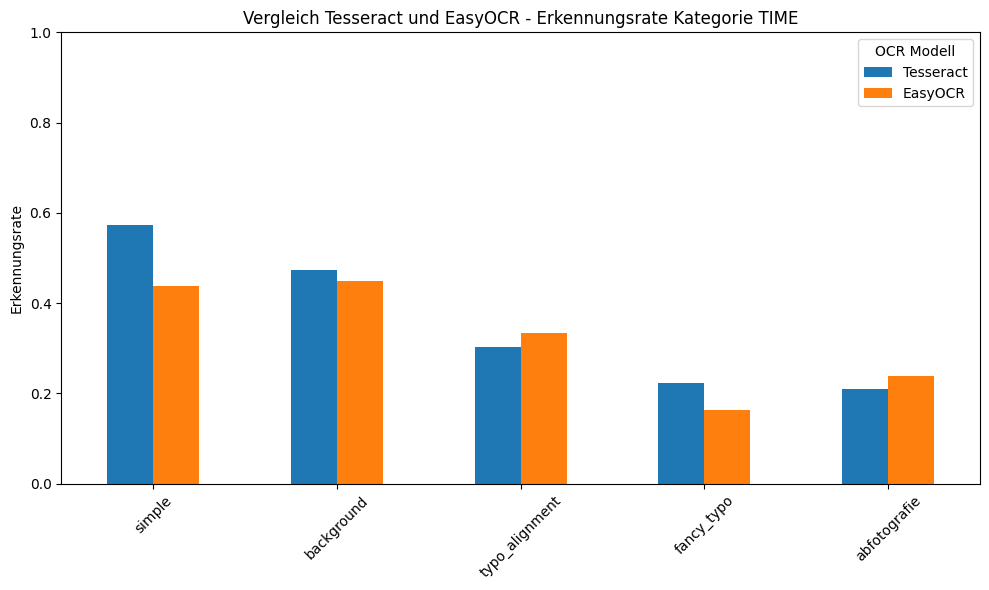

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Beispielhafte Daten – diese musst du mit deinen echten Werten ersetzen
category_easy= {
    'simple': 0.437500,
    'background': 0.447917,
    'typo_alignment': 0.333333,
    'fancy_typo': 0.164141,
    'abfotografie': 0.239130
}

category_tesser = {
    'simple': 0.573529,
    'background': 0.473958,
    'typo_alignment': 0.302083,
    'fancy_typo': 0.222222,
    'abfotografie': 0.210145
}





kategorie_reihenfolge = ['simple', 'background', 'typo_alignment', 'fancy_typo', 'abfotografie']

# In DataFrame umwandeln
df = pd.DataFrame({
    'Tesseract': category_tesser,
    'EasyOCR': category_easy,
})

# Sortierung einheitlich nach Kategorie
#df = df.sort_index()
df = df.loc[kategorie_reihenfolge]

# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Erkennungsrate')
plt.title('Vergleich Tesseract und EasyOCR - Erkennungsrate Kategorie TIME')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='OCR Modell')
plt.tight_layout()
plt.show()

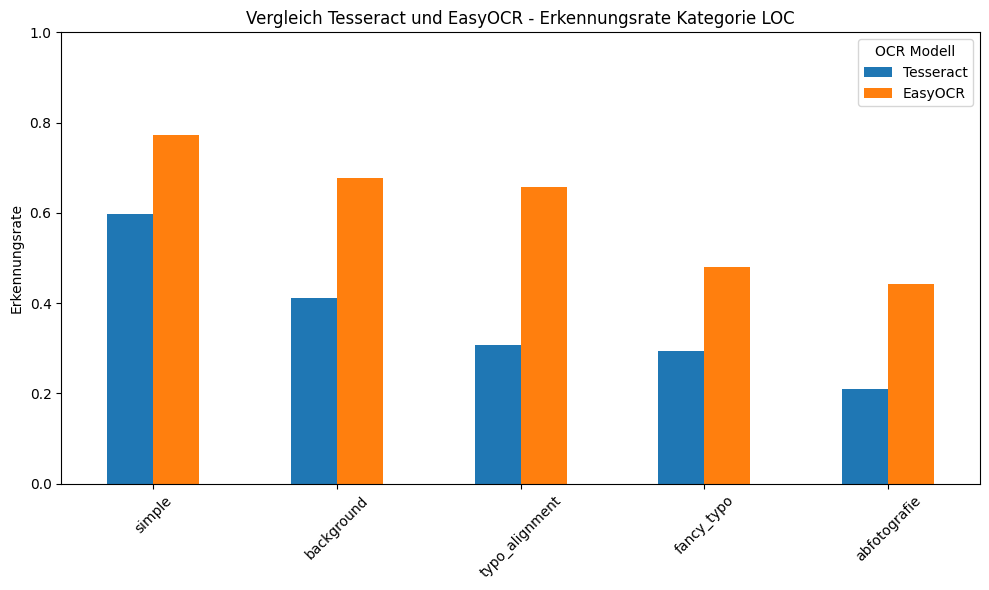

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Beispielhafte Daten – diese musst du mit deinen echten Werten ersetzen
category_easy= {
     'simple': 0.773529,
    'background': 0.677083,
    'typo_alignment': 0.656994,
    'fancy_typo': 0.481061,
    'abfotografie': 0.442029
}

category_tesser = {
    'simple': 0.596814,
    'background': 0.411458,
    'typo_alignment': 0.307292,
    'fancy_typo': 0.294192,
    'abfotografie': 0.210145
}





kategorie_reihenfolge = ['simple', 'background', 'typo_alignment', 'fancy_typo', 'abfotografie']

# In DataFrame umwandeln
df = pd.DataFrame({
    'Tesseract': category_tesser,
    'EasyOCR': category_easy,
})

# Sortierung einheitlich nach Kategorie
#df = df.sort_index()
df = df.loc[kategorie_reihenfolge]

# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Erkennungsrate')
plt.title('Vergleich Tesseract und EasyOCR - Erkennungsrate Kategorie LOC')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='OCR Modell')
plt.tight_layout()
plt.show()

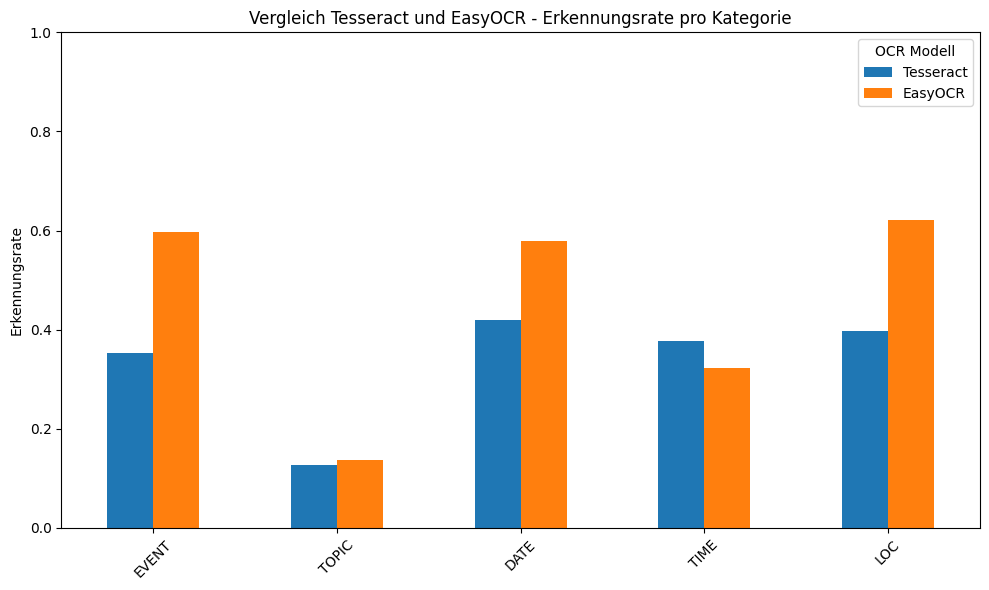

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Beispielhafte Daten – diese musst du mit deinen echten Werten ersetzen
category_easy= {
    'EVENT': 0.598,
    'TOPIC': 0.137,
    'DATE': 0.579,
    'TIME': 0.322,
    'LOC': 0.621
}

category_tesser = {
    'EVENT': 0.352,
    'TOPIC': 0.126,
    'DATE': 0.420,
    'TIME': 0.378,
    'LOC': 0.397
}


kategorie_reihenfolge = [
    'EVENT',
    'TOPIC',
    'DATE',
    'TIME',
    'LOC']

# In DataFrame umwandeln
df = pd.DataFrame({
    'Tesseract': category_tesser,
    'EasyOCR': category_easy,
})

# Sortierung einheitlich nach Kategorie
#df = df.sort_index()
df = df.loc[kategorie_reihenfolge]

# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Erkennungsrate')
plt.title('Vergleich Tesseract und EasyOCR - Erkennungsrate pro Kategorie')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='OCR Modell')
plt.tight_layout()
plt.show()

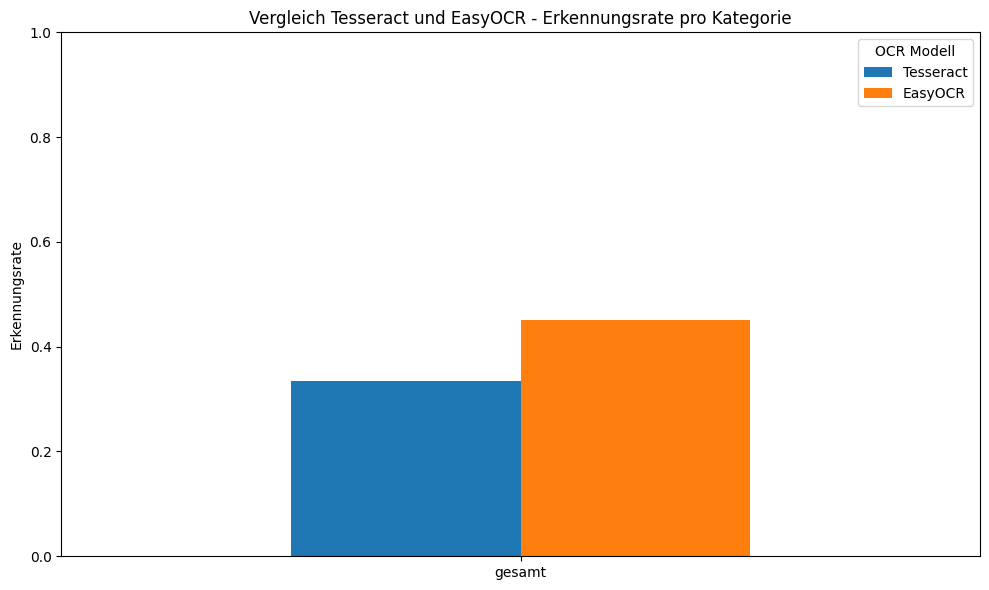

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Beispielhafte Daten – diese musst du mit deinen echten Werten ersetzen
category_easy= {
    'gesamt': 0.451,
    
}

category_tesser = {
    'gesamt': 0.335,
   
}




# In DataFrame umwandeln
df = pd.DataFrame({
    'Tesseract': category_tesser,
    'EasyOCR': category_easy,
})

# Sortierung einheitlich nach Kategorie
#df = df.sort_index()

# Plot
df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Erkennungsrate')
plt.title('Vergleich Tesseract und EasyOCR - Erkennungsrate pro Kategorie')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title='OCR Modell')
plt.tight_layout()
plt.show()